In [48]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy import mean, std

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# ignore future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

In [35]:
# load in the dataset
features = pd.read_csv('heloc_dataset_v1.csv')
features.replace([-9
                  , -8, -7
                 ], np.nan, inplace=True)

# the columns that stores the labels
labelDimension = "RiskPerformance"

original_rows = features.shape[0]

features = features.dropna(thresh=10) # Remove rows with more than 10 missing values
print("Removed rows:", original_rows - features.shape[0])
features.drop(features.columns[features.isnull().sum() > 1000], axis=1, inplace=True) # Drop columns with more than 1000 values missing

# bins = [0, 20, 40, 60, 80, 100]
# labels =[0, 1, 2, 3, 4]
# features['ExternalRiskEstimateCat'] = pd.cut(features['ExternalRiskEstimate'], bins, labels=labels)

categorical = [
#     'ExternalRiskEstimateCat', 
    'MaxDelqEver', 
    'MaxDelq/PublicRecLast12M'
]

X = features[features.columns[1:]]
numerical = [col for col in X.columns if col not in categorical]

y = features[labelDimension]
y_code = y.astype("category").cat.codes # Int representation of labels
for cat in categorical:
    X[cat] = X[cat].astype("category")

Removed rows: 588


C:\Users\adubo\AppData\Local\Temp\ipykernel_33712\1722258598.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat] = X[cat].astype("category")
C:\Users\adubo\AppData\Local\Temp\ipykernel_33712\1722258598.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat] = X[cat].astype("category")


In [15]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

model = RandomForestClassifier(n_estimators = 1500)

imputer = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='mean'), numerical), 
    ('cat', SimpleImputer(strategy='most_frequent'), categorical)
])

num_pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder())
transformer = ColumnTransformer(transformers=[('num', num_pipe, numerical), ('cat', cat_pipe, categorical)])

In [36]:
columns = list(numerical) + list(categorical)
X_transform = pd.DataFrame(transformer.fit_transform(X), columns=columns)

X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X_transform, y_code, stratify=y_code, train_size = 0.8, random_state=0)

# Impute values
X_np = imputer.fit_transform(X)
X = pd.DataFrame(X_np, columns=columns)
X_train, X_test, y_train, y_test = train_test_split(X, y_code, stratify=y_code, train_size = 0.8, random_state=0)

In [17]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
labelled_correctly = y_pred == y_test
y_pred_prob = model.predict_proba(X_test)[:, 1]

C:\Users\adubo\AppData\Local\Temp\ipykernel_33712\1486367421.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(columns)


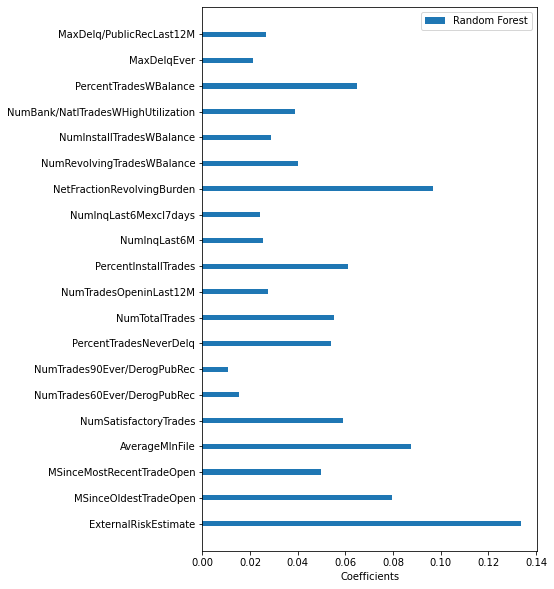

In [18]:
# Feature importances
df = pd.DataFrame({'names': columns, 
                   'random_forest': model.feature_importances_})

fig, ax = plt.subplots(figsize=(6, 10))
ind = np.arange(len(df))
width = 0.2
ax.barh(ind, df.random_forest, width, label='Random Forest')
ax.set_yticklabels(columns)
ax.set_yticks(np.arange(len(columns)))
ax.set_xlabel('Coefficients')
ax.legend()
plt.show()

Text(0.5, 1.0, 'Permutation Importances (test set)')

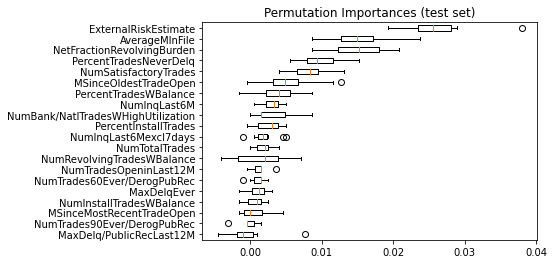

In [19]:
# Permutation Importances
from sklearn.inspection import permutation_importance
 
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0) # Takes a long time
sorted_idx = perm_importance.importances_mean.argsort()
plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=np.array(columns)[sorted_idx])
plt.title("Permutation Importances (test set)")

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

X_embed = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_test_transformed)

In [21]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=4).fit(X_test_transformed)
# clustering_labels = kmeans.labels_
# plt.scatter(X_embed[:, 0], X_embed[:, 1], c=clustering_labels, s=1)
# plt.colorbar()

In [22]:
# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=5, min_samples=20).fit(X_test_transformed)
# clustering_labels = dbscan.labels_

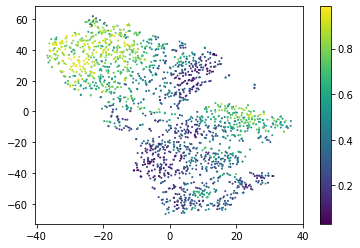

In [23]:
# Plot prediction probabilities across samples - also allow for other params!
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=y_pred_prob, s=1)
plt.colorbar()

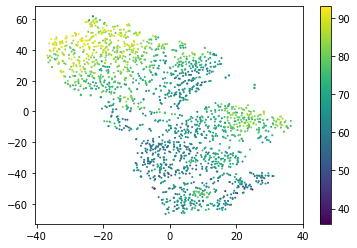

In [39]:
# labels - any of the col names
labels = X_test['ExternalRiskEstimate'].tolist()
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=labels, s=1)
plt.colorbar()


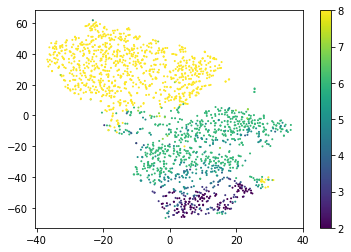

In [40]:
labels = X_test[categorical[0]].tolist()
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=labels, s=1)
plt.colorbar()

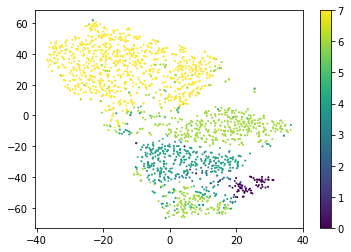

In [41]:
labels = X_test[categorical[1]].tolist()
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=labels, s=1)
plt.colorbar()

In [42]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA()
components = pca.fit_transform(X_test_transformed)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix( 
    components,
    labels=labels,
    dimensions=range(4),
    color=y_pred_prob
)
fig.update_traces(diagonal_visible=True)
fig.show()

In [43]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_test_transformed)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=y_pred_prob)


for i, dim in enumerate(X.columns.tolist()):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=dim,
    )
fig.show()

In [46]:
# DiCE counterfactual explanations
from dice_ml import Data, Model, Dice

df = X_train
df['y'] = y_train
data = Data(
    dataframe=df, 
    continuous_features=numerical, 
    outcome_name='y'
)
m = Model(model=model, backend='sklearn')
dice = Dice(data, m, method='random')

In [51]:
e = dice.generate_counterfactuals(X_test[:5], total_CFs=5, desired_class="opposite")
e.visualize_as_dataframe(show_only_changes=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.71s/it]

Query instance (original outcome : 0)


ExternalRiskEstimate  MSinceOldestTradeOpen  MSinceMostRecentTradeOpen  \
0                  75.0                  113.0                       97.0   

   AverageMInFile  NumSatisfactoryTrades  NumTrades60Ever/DerogPubRec  \
0           105.0                    2.0                          0.0   

   NumTrades90Ever/DerogPubRec  PercentTradesNeverDelq  NumTotalTrades  \
0                          0.0                   100.0             2.0   

   NumTradesOpeninLast12M  ...  NumInqLast6M  NumInqLast6Mexcl7days  \
0                     0.0  ...           0.0                    0.0   

   NetFractionRevolvingBurden  NumRevolvingTradesWBalance  \
0                       101.0                         2.0   

   NumInstallTradesWBalance  NumBank/NatlTradesWHighUtilization  \
0                  2.484906                                 1.0   

   PercentTradesWBalance  MaxDelqEver  MaxDelq/PublicRecLast12M  y  
0                  100.0          8.0                       7.0  0  

[1 rows x 21 columns]


Diverse Counterfactual set (new outcome: 1.0)


ExternalRiskEstimate MSinceOldestTradeOpen MSinceMostRecentTradeOpen  \
0                    -                     -                         -   
1                    -                     -                         -   
2                    -                     -                         -   
3                    -                     -                         -   
4                    -                     -                         -   

  AverageMInFile NumSatisfactoryTrades NumTrades60Ever/DerogPubRec  \
0              -                  13.3                           -   
1              -                  59.4                           -   
2              -                   7.9                           -   
3              -                  37.6                           -   
4              -                  76.0                           -   

  NumTrades90Ever/DerogPubRec PercentTradesNeverDelq NumTotalTrades  \
0                           -                      -              -   
1                           -                      -              -   
2                           -                      -              -   
3                           -                      -              -   
4                           -                      -              -   

  NumTradesOpeninLast12M  ... NumInqLast6M NumInqLast6Mexcl7days  \
0                      -  ...            -                     -   
1                      -  ...            -                     -   
2                      -  ...            -                     -   
3                      -  ...            -                  64.6   
4                      -  ...            -                     -   

  NetFractionRevolvingBurden NumRevolvingTradesWBalance  \
0                          -                          -   
1                          -                          -   
2                          -                          -   
3                          -                          -   
4                          -                          -   

  NumInstallTradesWBalance NumBank/NatlTradesWHighUtilization  \
0        3.084905660377359                                  -   
1        3.084905660377359                                  -   
2        3.084905660377359                                  -   
3        3.084905660377359                                  -   
4                     22.3                                  -   

  PercentTradesWBalance MaxDelqEver MaxDelq/PublicRecLast12M  y  
0                     -           -                        -  1  
1                     -           -                        -  1  
2                     -           -                        -  1  
3                     -           -                        -  1  
4                     -           -                        -  1  

[5 rows x 21 columns]

Query instance (original outcome : 1)


ExternalRiskEstimate  MSinceOldestTradeOpen  MSinceMostRecentTradeOpen  \
0                  82.0                   86.0                        3.0   

   AverageMInFile  NumSatisfactoryTrades  NumTrades60Ever/DerogPubRec  \
0            40.0                    9.0                          0.0   

   NumTrades90Ever/DerogPubRec  PercentTradesNeverDelq  NumTotalTrades  \
0                          0.0                   100.0            10.0   

   NumTradesOpeninLast12M  ...  NumInqLast6M  NumInqLast6Mexcl7days  \
0                     2.0  ...           1.0                    1.0   

   NetFractionRevolvingBurden  NumRevolvingTradesWBalance  \
0                        16.0                         2.0   

   NumInstallTradesWBalance  NumBank/NatlTradesWHighUtilization  \
0                       2.0                                 0.0   

   PercentTradesWBalance  MaxDelqEver  MaxDelq/PublicRecLast12M  y  
0                   50.0          8.0                       7.0  1  

[1 rows x 21 columns]


Diverse Counterfactual set (new outcome: 0.0)


ExternalRiskEstimate MSinceOldestTradeOpen MSinceMostRecentTradeOpen  \
0                 74.6                     -                         -   
1                 75.1                     -                         -   
2                    -                     -                         -   
3                    -                     -                         -   
4                    -                     -                         -   

  AverageMInFile NumSatisfactoryTrades NumTrades60Ever/DerogPubRec  \
0              -                     -                           -   
1              -                   3.6                           -   
2              -                     -                           -   
3              -                     -                           -   
4              -                     -                           -   

  NumTrades90Ever/DerogPubRec PercentTradesNeverDelq NumTotalTrades  \
0                           -                      -              -   
1                           -                      -              -   
2                           -                      -              -   
3                           -                      -              -   
4                           -                      -              -   

  NumTradesOpeninLast12M  ... NumInqLast6M NumInqLast6Mexcl7days  \
0                      -  ...            -                     -   
1                      -  ...            -                     -   
2                      -  ...            -                     -   
3                      -  ...            -                     -   
4                      -  ...            -                  47.4   

  NetFractionRevolvingBurden NumRevolvingTradesWBalance  \
0                          -                       29.2   
1                          -                          -   
2                      206.5                          -   
3                      228.4                          -   
4                      178.6                          -   

  NumInstallTradesWBalance NumBank/NatlTradesWHighUtilization  \
0                        -                                  -   
1                        -                                  -   
2                        -                                  -   
3                        -                                  -   
4                        -                                  -   

  PercentTradesWBalance MaxDelqEver MaxDelq/PublicRecLast12M  y  
0                     -           -                        -  0  
1                     -           -                        -  0  
2                     -           -                        -  0  
3                     -           -                        -  0  
4                     -           -                        -  0  

[5 rows x 21 columns]

Query instance (original outcome : 1)


ExternalRiskEstimate  MSinceOldestTradeOpen  MSinceMostRecentTradeOpen  \
0                  84.0                  128.0                        7.0   

   AverageMInFile  NumSatisfactoryTrades  NumTrades60Ever/DerogPubRec  \
0            81.0                   13.0                          0.0   

   NumTrades90Ever/DerogPubRec  PercentTradesNeverDelq  NumTotalTrades  \
0                          0.0                   100.0            14.0   

   NumTradesOpeninLast12M  ...  NumInqLast6M  NumInqLast6Mexcl7days  \
0                     1.0  ...           3.0                    3.0   

   NetFractionRevolvingBurden  NumRevolvingTradesWBalance  \
0                         0.0                         1.0   

   NumInstallTradesWBalance  NumBank/NatlTradesWHighUtilization  \
0                       1.0                                 0.0   

   PercentTradesWBalance  MaxDelqEver  MaxDelq/PublicRecLast12M  y  
0                   33.0          8.0                       7.0  1  

[1 rows x 21 columns]


Diverse Counterfactual set (new outcome: 0.0)


ExternalRiskEstimate MSinceOldestTradeOpen MSinceMostRecentTradeOpen  \
0                 52.6                     -                         -   
1                    -                     -                         -   
2                    -                     -                         -   
3                    -                     -                         -   
4                    -                     -                         -   

  AverageMInFile NumSatisfactoryTrades NumTrades60Ever/DerogPubRec  \
0              -                     -                         9.0   
1              -                     -                           -   
2              -                     -                           -   
3              -                     -                           -   
4              -                     -                           -   

  NumTrades90Ever/DerogPubRec PercentTradesNeverDelq NumTotalTrades  \
0                           -                      -              -   
1                           -                      -              -   
2                           -                      -              -   
3                           -                      -              -   
4                           -                      -              -   

  NumTradesOpeninLast12M  ... NumInqLast6M NumInqLast6Mexcl7days  \
0                      -  ...            -                     -   
1                      -  ...            -                     -   
2                      -  ...            -                     -   
3                      -  ...            -                     -   
4                      -  ...            -                     -   

  NetFractionRevolvingBurden NumRevolvingTradesWBalance  \
0                          -                          -   
1                      156.6                          -   
2                      199.5                       25.2   
3                      230.5                          -   
4                      119.8                          -   

  NumInstallTradesWBalance NumBank/NatlTradesWHighUtilization  \
0                        -                                  -   
1                        -                                  -   
2                        -                                  -   
3                        -                                  -   
4                        -                                  -   

  PercentTradesWBalance MaxDelqEver MaxDelq/PublicRecLast12M  y  
0                     -           -                        -  0  
1                     -           -                        -  0  
2                     -           -                        -  0  
3                     -           -                        -  0  
4                     -           -                      3.0  0  

[5 rows x 21 columns]

Query instance (original outcome : 0)


ExternalRiskEstimate  MSinceOldestTradeOpen  MSinceMostRecentTradeOpen  \
0                  58.0                  164.0                        4.0   

   AverageMInFile  NumSatisfactoryTrades  NumTrades60Ever/DerogPubRec  \
0            62.0                   21.0                          2.0   

   NumTrades90Ever/DerogPubRec  PercentTradesNeverDelq  NumTotalTrades  \
0                          1.0                    70.0            24.0   

   NumTradesOpeninLast12M  ...  NumInqLast6M  NumInqLast6Mexcl7days  \
0                     4.0  ...           5.0                    5.0   

   NetFractionRevolvingBurden  NumRevolvingTradesWBalance  \
0                        27.0                         5.0   

   NumInstallTradesWBalance  NumBank/NatlTradesWHighUtilization  \
0                       4.0                                 0.0   

   PercentTradesWBalance  MaxDelqEver  MaxDelq/PublicRecLast12M  y  
0                   82.0          5.0                       4.0  0  

[1 rows x 21 columns]


Diverse Counterfactual set (new outcome: 1.0)


ExternalRiskEstimate MSinceOldestTradeOpen MSinceMostRecentTradeOpen  \
0                 86.7                     -                         -   
1                 86.7                     -                         -   
2                 86.7                     -                         -   
3                 88.1                     -                         -   
4                 82.8                     -                     296.6   

  AverageMInFile NumSatisfactoryTrades NumTrades60Ever/DerogPubRec  \
0          258.6                     -                           -   
1          258.6                     -                           -   
2          258.6                     -                           -   
3          165.6                  56.8                           -   
4              -                     -                           -   

  NumTrades90Ever/DerogPubRec PercentTradesNeverDelq NumTotalTrades  \
0                           -                   98.9              -   
1                           -                   98.9              -   
2                           -                   98.9              -   
3                           -                      -              -   
4                           -                   25.9           54.7   

  NumTradesOpeninLast12M  ... NumInqLast6M NumInqLast6Mexcl7days  \
0                      -  ...            -                     -   
1                      -  ...            -                     -   
2                      -  ...            -                     -   
3                      -  ...         40.2                     -   
4                    1.4  ...            -                     -   

  NetFractionRevolvingBurden NumRevolvingTradesWBalance  \
0                          -                          -   
1                          -                          -   
2                          -                          -   
3                          -                          -   
4                          -                          -   

  NumInstallTradesWBalance NumBank/NatlTradesWHighUtilization  \
0                        -                                  -   
1                        -                                  -   
2                        -                                  -   
3                        -                                  -   
4                        -                                  -   

  PercentTradesWBalance MaxDelqEver MaxDelq/PublicRecLast12M  y  
0                     -           -                        -  1  
1                     -         5.0                        -  1  
2                  16.7         5.0                        -  1  
3      82.0999999999999           -                      9.0  1  
4                  33.3           -                      7.0  1  

[5 rows x 21 columns]

Query instance (original outcome : 0)


ExternalRiskEstimate  MSinceOldestTradeOpen  MSinceMostRecentTradeOpen  \
0                  64.0                  302.0                        0.0   

   AverageMInFile  NumSatisfactoryTrades  NumTrades60Ever/DerogPubRec  \
0            59.0                   17.0                          1.0   

   NumTrades90Ever/DerogPubRec  PercentTradesNeverDelq  NumTotalTrades  \
0                          1.0                   100.0            19.0   

   NumTradesOpeninLast12M  ...  NumInqLast6M  NumInqLast6Mexcl7days  \
0                     3.0  ...           2.0                    2.0   

   NetFractionRevolvingBurden  NumRevolvingTradesWBalance  \
0                        82.0                         4.0   

   NumInstallTradesWBalance  NumBank/NatlTradesWHighUtilization  \
0                       2.0                                 2.0   

   PercentTradesWBalance  MaxDelqEver  MaxDelq/PublicRecLast12M  y  
0                   86.0          8.0                       7.0  0  

[1 rows x 21 columns]


Diverse Counterfactual set (new outcome: 1.0)


ExternalRiskEstimate MSinceOldestTradeOpen MSinceMostRecentTradeOpen  \
0                 93.3                     -                         -   
1                 81.6                     -                         -   
2                    -                     -                         -   
3                 85.4                     -                         -   
4                    -                     -                      70.7   

  AverageMInFile NumSatisfactoryTrades NumTrades60Ever/DerogPubRec  \
0          380.4                     -                           -   
1          350.6                     -                           -   
2          176.7                  65.1                           -   
3          330.0                     -                           -   
4              -                  53.8                           -   

  NumTrades90Ever/DerogPubRec PercentTradesNeverDelq NumTotalTrades  \
0                           -                      -              -   
1                           -                      -              -   
2                           -                      -              -   
3                           -                      -              -   
4                           -                      -              -   

  NumTradesOpeninLast12M  ... NumInqLast6M NumInqLast6Mexcl7days  \
0                      -  ...            -                     -   
1                      -  ...            -                     -   
2                      -  ...            -                     -   
3                      -  ...            -                     -   
4                      -  ...            -                     -   

  NetFractionRevolvingBurden NumRevolvingTradesWBalance  \
0                          -                          -   
1                          -                          -   
2                          -                          -   
3                          -                          -   
4                          -                          -   

  NumInstallTradesWBalance NumBank/NatlTradesWHighUtilization  \
0                        -                                  -   
1                        -                                  -   
2                     19.8                                  -   
3                        -                                  -   
4                     11.6                                  -   

  PercentTradesWBalance MaxDelqEver MaxDelq/PublicRecLast12M  y  
0                     -           -                      6.0  1  
1                     -           -                        -  1  
2                     -           -                        -  1  
3                     -           -                        -  1  
4                     -           -                        -  1  

[5 rows x 21 columns]

In [57]:
e.visualize_as_list(show_only_changes=True)

Query instance (original outcome : 0)
[75.0, 113.0, 97.0, 105.0, 2.0, 0.0, 0.0, 100.0, 2.0, 0.0, 0.0, 0.0, 0.0, 101.0, 2.0, 2.4849056603773585, 1.0, 100.0, 8.0, 7.0, 0.0]

Diverse Counterfactual set (new outcome: 1.0)
['-', '-', '-', '-', 13.3, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 3.084905660377359, '-', '-', '-', '-', 1]
['-', '-', '-', '-', 59.4, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 3.084905660377359, '-', '-', '-', '-', 1]
['-', '-', '-', '-', 7.9, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 3.084905660377359, '-', '-', '-', '-', 1]
['-', '-', '-', '-', 37.6, '-', '-', '-', '-', '-', '-', '-', 64.6, '-', '-', 3.084905660377359, '-', '-', '-', '-', 1]
['-', '-', '-', '-', 76.0, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 22.3, '-', '-', '-', '-', 1]
Query instance (original outcome : 1)
[82.0, 86.0, 3.0, 40.0, 9.0, 0.0, 0.0, 100.0, 10.0, 2.0, 30.0, 1.0, 1.0, 16.0, 2.0, 2.0, 0.0, 50.0, 8.0, 7.0, 1.0]

Diverse Counterfactual set (new outcome: 0.0)


In [ ]:
import shap 

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)[1] #Takes a long time

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0,:], X_test.iloc[0,:])

In [ ]:
shap.dependence_plot("ExternalRiskEstimate", shap_values, X_test)

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    X_train.values, 
    mode='classification', 
    feature_names=X_train_transformed.columns, 
    verbose=True
)

In [ ]:
exp = explainer.explain_instance(X_test.to_numpy()[1000], model.predict_proba)
exp.show_in_notebook(show_table=True)

In [ ]:
exp.as_list()